### Purpose:
 - Download retrospective hourly analysis & assimilation NWM files from the Google Cloud archive
 - Obtain and plot the discharge time series of a stream of interest
 - Run the cells in order to import libraries, select parameters, define functions, download files, and plot a discharge series
    
### Inputs:
 - (1) begin date for data retrieval
 - (2) end date for data retrieval (inclusive)
 - (3) desired product (channel routing or forcing)
 - (4) directory for downloaded files

In [2]:
# import python libraries

import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sys
import xarray as xr

from matplotlib.dates import DateFormatter
from time import sleep

In [3]:
# select input parameters

begindate = '20190929' # data is avail. beginning 20180917
enddate = '20190930'
# enddate = '20190930' # inclusive
product = 'channel_rt' # 'channel_rt' or 'forcing'
destfolder_name = 'test2' # directory will be created in current working directory if it does not already exist

In [4]:
# define functions

def get_netcdf(filetype,begin_date,end_date,output_folder_name):
    
    output_folder = os.path.join(os.getcwd(),output_folder_name)
    
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    if filetype =='channel_rt':
        prodstr = ''
    elif filetype == 'forcing':
        prodstr = 'forcing_'
    else:
        print("Product error. Choose 'channel_rt' or 'forcing'.")
        sys.exit()
    
        
    
    t1 = pd.to_datetime(begin_date)
    t2 = pd.to_datetime(end_date)
    dates = pd.date_range(t1,t2)
    
    for i in range(len(dates)):
        date = dates[i]
        save_dir = date.strftime('%Y%m%d')
        
        if not os.path.exists(output_folder+'/'+save_dir):
            os.mkdir(output_folder+'/'+save_dir)
            
        for hr in range(24):
            
            # url = f'https://storage.googleapis.com/national-water-model/' \
            #       f'nwm.{date.strftime("%Y%m%d")}/{prodstr}analysis_assim/' \
            #       f'nwm.t{str(hr).zfill(2)}z.analysis_assim.{filetype}.tm00.conus.nc'
            url = f'https://storage.googleapis.com/national-water-model/' \
                  f'nwm.{date.strftime("%Y%m%d")}/{prodstr}short_range/' \
                  f'nwm.t{str(hr).zfill(2)}z.short_range.{filetype}.f001.conus.nc'
                #   https://storage.googleapis.com/national-water-model/nwm.20200404/analysis_assim/nwm.t00z.analysis_assim.channel_rt.tm00.conus.nc
                #   https://storage.googleapis.com/national-water-model/nwm.20200404/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
            # url = 'https://storage.googleapis.com/national-water-model/nwm/prod/nwm.20190917/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'
            filename = os.path.basename(url)
            write_file = os.path.join(output_folder, save_dir, filename)

            for attempt in range(30):
                try:
                    r = requests.get(url)
                    with open(write_file, 'wb') as f:
                        f.write(r.content)
                    break
                except Exception as ex:
                    if attempt != max_attempts - 1:
                        sleep(0.5)  # Give NOAA time to wake up
                    else:
                        m = 'Could not download file.\n' + str(ex)
                        raise Exception(m)
                        
        print(f'{save_dir} done')
       
        
def get_series(comid, begin_date, end_date, datafolder_name, filetype):
    
    data_folder = os.path.join(os.getcwd(), datafolder_name)
    
    t1 = pd.to_datetime(begin_date)
    t2 = pd.to_datetime(end_date)
    dates = pd.date_range(t1,t2)
    
    df = pd.DataFrame()
    
    for i in range(len(dates)):
        date = dates[i]
        date_dir = date.strftime('%Y%m%d')
            
        for hr in range(24):
            # filename = f'nwm.t{str(hr).zfill(2)}z.analysis_assim.{filetype}.f001.conus.nc'
            filename = f'nwm.t{str(hr).zfill(2)}z.short_range.{filetype}.f001.conus.nc'
            # nwm.t00z.short_range.channel_rt.f001.conus.nc
            nc_file = os.path.join(data_folder, date_dir, filename)
            data = xr.open_dataset(nc_file)
            Q = float(data.sel(feature_id=comid).streamflow.values)
            timestamp = pd.to_datetime(f'{date_dir} {hr}:00')
            df.loc[timestamp,'Q'] = Q
    
    return df
    


In [5]:
# download files

get_netcdf(product,begindate,enddate,destfolder_name)

20190929 done
20190930 done


In [6]:
# extract a discharge time series for an individual stream from the downloaded files
# this example shows a reach of the Sabine River in Southeast Texas during TS Imelda
# compare: https://nwis.waterdata.usgs.gov/nwis/uv?cb_00060=on&cb_00065=on&format=gif_default&site_no=08030500&period=&begin_date=2019-09-15&end_date=2019-09-30

comid = 1114345
# 1114345 # Neches River Saltwater Barrier 8331880 # Sabine river near USGS gage 08030500
sabine_timeseries_df = get_series(comid, begindate, enddate, destfolder_name, product)
print (sabine_timeseries_df)

                              Q
2019-09-29 00:00:00  375.109992
2019-09-29 01:00:00  372.489992
2019-09-29 02:00:00  369.889992
2019-09-29 03:00:00  367.309992
2019-09-29 04:00:00  364.749992
2019-09-29 05:00:00  362.219992
2019-09-29 06:00:00  359.699992
2019-09-29 07:00:00  357.209992
2019-09-29 08:00:00  354.739992
2019-09-29 09:00:00  352.289992
2019-09-29 10:00:00  349.859992
2019-09-29 11:00:00  347.459992
2019-09-29 12:00:00  345.079992
2019-09-29 13:00:00  342.719992
2019-09-29 14:00:00  340.389992
2019-09-29 15:00:00  338.089992
2019-09-29 16:00:00  335.809992
2019-09-29 17:00:00  333.569993
2019-09-29 18:00:00  331.349993
2019-09-29 19:00:00  329.089993
2019-09-29 20:00:00  326.909993
2019-09-29 21:00:00  324.769993
2019-09-29 22:00:00  322.649993
2019-09-29 23:00:00  320.559993
2019-09-30 00:00:00  318.489993
2019-09-30 01:00:00  316.449993
2019-09-30 02:00:00  314.439993
2019-09-30 03:00:00  312.449993
2019-09-30 04:00:00  310.479993
2019-09-30 05:00:00  308.529993
2019-09-

In [14]:
#Combining with the USGS / DD6 gages Get the USGS file
headers = ['Discharge', 'Time']
df = pd.read_csv('usgs.csv', names = headers)
usgs_x = []
usgs_y = []
for row in df
    usgs_x.append(df.)
# usgs_x = list(var['Time'])
# usgs_y = list(var['Discharge'])
# print(usgs_x, usgs_y)

SyntaxError: invalid syntax (Temp/ipykernel_141576/1109527966.py, line 6)

<Figure size 432x288 with 0 Axes>

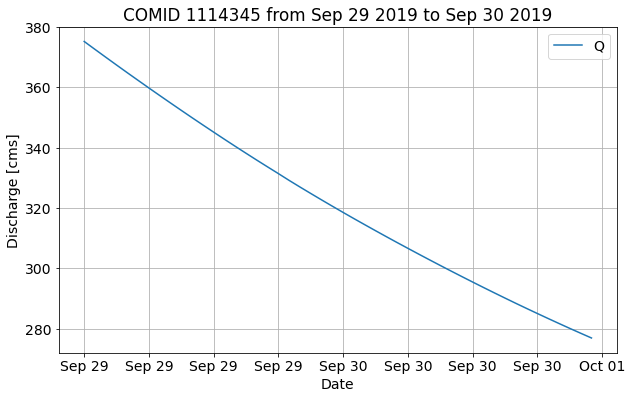

In [15]:
# plot the discharge time series
plt.figure(facecolor='white')
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sabine_timeseries_df, color='tab:blue', label='Q')
ax.set(xlabel='Date',
       ylabel='Discharge [cms]',
       title=f'COMID {comid} from ' \
       f'{pd.to_datetime(begindate).strftime("%b %d %Y")} to ' \
       f'{pd.to_datetime(enddate).strftime("%b %d %Y")}')
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.grid(True)
plt.savefig('Discharge_graph.jpg')